In [1]:
%matplotlib inline

import os
import sys
import datacube
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

sys.path.append("Scripts")
from dea_plotting import display_map
from dea_datahandling import wofs_fuser
from dea_plotting import rgb
from dea_datahandling import load_ard
from dea_bandindices import calculate_indices

In [4]:
dc = datacube.Datacube(app="Regression_test")

In [71]:
# setting some appropriate variables

lat = (-34,-34.5)
lon = (145,145.5)
time = ("2015-01-25","2015-05-22")

In [72]:
# querying for some data to test the regression against

query = {'x':lon,
        'y':lat,
        'time':time,
        'output_crs':'EPSG:3577',
        'resolution':(-25,25),
        'measurements':['nbart_swir_1','nbart_red','nbart_blue','nbart_green','nbart_swir_2','nbart_panchromatic','nbart_nir'],
        'group_by':'solar_day'
        }
regress = dc.load(product='ga_ls8c_ard_3',**query)

In [73]:
# NDVI indexing for use in the regreswsion comparison

regress['NDVI'] = (regress.nbart_nir-regress.nbart_red)/(regress.nbart_nir+regress.nbart_red)

In [74]:
# normalising the swir_1 (band 6) as an index relative to its maximum and minimum
swir_1_max = regress.nbart_swir_1.max()
swir_1_min = regress.nbart_swir_1.min()

regress["NSWIR"] = (regress.nbart_swir_1-swir_1_min)/(swir_1_max-swir_1_min)

In [75]:
print(regress)

<xarray.Dataset>
Dimensions:             (time: 7, x: 2056, y: 2407)
Coordinates:
  * time                (time) datetime64[ns] 2015-02-09T00:08:19.307218 ... 2015-05-16T00:07:27.099849
  * y                   (y) float64 -3.771e+06 -3.772e+06 ... -3.832e+06
  * x                   (x) float64 1.187e+06 1.187e+06 ... 1.238e+06 1.238e+06
Data variables:
    nbart_swir_1        (time, y, x) int16 3346 3278 3342 ... 2024 2008 1995
    nbart_red           (time, y, x) int16 1633 1587 1628 ... 1104 1083 1084
    nbart_blue          (time, y, x) int16 961 940 968 1002 ... 575 567 555 553
    nbart_green         (time, y, x) int16 1319 1275 1315 1371 ... 841 832 830
    nbart_swir_2        (time, y, x) int16 2706 2660 2708 ... 1555 1528 1528
    nbart_panchromatic  (time, y, x) int16 1420 1365 1413 1443 ... 912 834 872
    nbart_nir           (time, y, x) int16 2769 2706 2771 ... 1488 1464 1477
    NDVI                (time, y, x) float64 0.2581 0.2607 ... 0.1496 0.1535
    NSWIR             

In [76]:
regress.NSWIR

<xarray.DataArray 'NSWIR' (time: 7, y: 2407, x: 2056)>
array([[[0.334533, 0.327733, ..., 0.462246, 0.461546],
        [0.338834, 0.336034, ..., 0.475248, 0.471347],
        ...,
        [0.441144, 0.448045, ..., 0.270127, 0.270127],
        [0.438744, 0.442144, ..., 0.258726, 0.253525]],

       [[0.334233, 0.329933, ..., 0.477048, 0.466247],
        [0.341434, 0.339734, ..., 0.475848, 0.475648],
        ...,
        [0.436444, 0.443544, ..., 0.19762 , 0.19762 ],
        [0.425643, 0.428743, ..., 0.193019, 0.192519]],

       ...,

       [[0.370137, 0.362536, ..., 0.269827, 0.269327],
        [0.377838, 0.373237, ..., 0.294629, 0.29583 ],
        ...,
        [0.19572 , 0.20132 , ..., 0.214121, 0.214121],
        [0.187519, 0.19632 , ..., 0.215922, 0.215522]],

       [[0.286629, 0.277828, ..., 0.494949, 0.483848],
        [0.29553 , 0.290729, ..., 0.493649, 0.49975 ],
        ...,
        [0.414841, 0.427043, ..., 0.19792 , 0.19792 ],
        [0.39774 , 0.410341, ..., 0.20072 , 0.199

In [77]:
# creating the constants for the analysis
c1 = 1.19104356*10**(-16)
c2 = 1.43876869*10**(-2)
wlen = 1.61*10**(-6)
K1 = c1/(wlen**5)
K2 = c2/wlen

regress["t_bright"] = K2/np.log((K1/regress.NSWIR)+1)-273.15

In [78]:
regress.t_bright

<xarray.DataArray 't_bright' (time: 7, y: 2407, x: 2056)>
array([[[13.966119, 13.776785, ..., 16.980325, 16.96605 ],
        [14.083994, 14.007398, ..., 17.241835, 17.164092],
        ...,
        [16.540862, 16.686697, ..., 12.006937, 12.006937],
        [16.489637, 16.562129, ..., 11.61509 , 11.430955]],

       [[13.957842, 13.838439, ..., 17.277516, 17.061515],
        [14.154591, 14.108489, ..., 17.253743, 17.249775],
        ...,
        [16.440299, 16.591828, ...,  9.191091,  9.191091],
        [16.205325, 16.273337, ...,  8.981131,  8.958028]],

       ...,

       [[14.902108, 14.709587, ..., 11.996825, 11.979949],
        [15.093427, 14.979576, ..., 12.799181, 12.83638 ],
        ...,
        [ 9.104929,  9.356675, ...,  9.908308,  9.908308],
        [ 8.72385 ,  9.132223, ...,  9.98339 ,  9.966756]],

       [[12.547499, 12.262937, ..., 17.625646, 17.411183],
        [12.827093, 12.677296, ..., 17.600762, 17.716997],
        ...,
        [15.964707, 16.236097, ...,  9.204624

In [79]:
# creating the fractional cover index

regress["frac_cov"] = ((regress.NDVI-regress.NDVI.min())/(regress.NDVI.max()-regress.NDVI.min()))**2

In [80]:
# emissivity calculations
regress["em"] = 0.986-(0.986-0.928)*regress.frac_cov

In [81]:
# land surface temperature calculation

regress["lst"] = (regress.t_bright)/(1+((wlen*regress.t_bright)/c2)*np.log(regress.em))

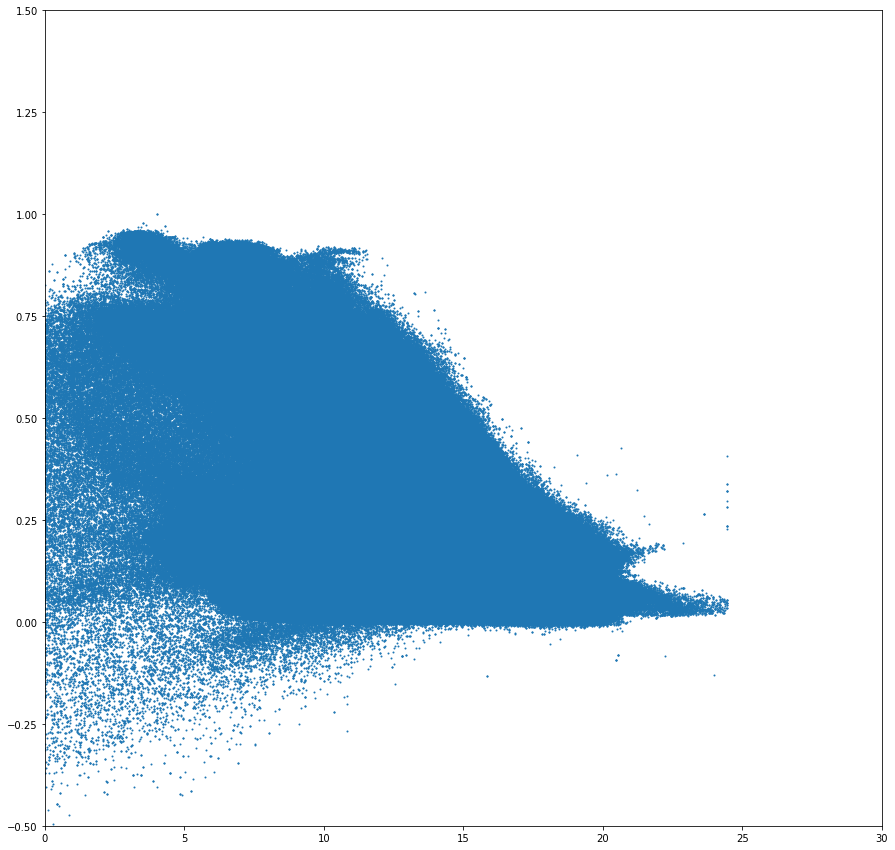

In [82]:
y_axis = regress.NDVI
x_axis = regress.lst

plt.figure(figsize=(15,15))
plt.scatter(x_axis,y_axis,s=1)
plt.ylim(-0.5,1.5)
plt.xlim(0,30)
plt.show()

In [83]:
display_map(x=lon,y=lat)

AttributeError: 'Rectangle' object has no property 'cmap'

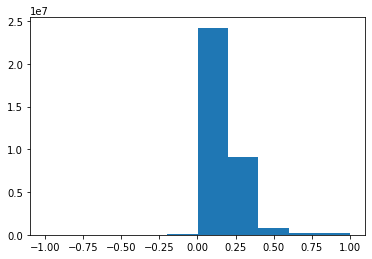

In [84]:
regress.NDVI.plot(cmap="RdBu")